# Supervised Learning - Ensemble Modeling, Random Forest Tree, Bagging, Boosting, Stacking and Voting 

In [ ]:
# Build an ensemble model to correctly classify the ratings of company based on cocoa bean production and improve your model prediction by using GridSearchCV.

In [1]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as skmet
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import VotingClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
comp_data = pd.read_excel(r"D:\360digi\DS\Sharath\Ensemble_Technique_2\handson\Datasets_ET\Coca_Rating_Ensemble.xlsx")#, encoding='utf-8')
comp_data

,Company,Name,REF,Review,Cocoa_Percent,Company_Location,Rating,Bean_Type,Origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,0.70,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,0.65,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,0.65,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,0.62,Austria,3.25,,India


In [4]:
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1795 non-null   object 
 1   Name              1795 non-null   object 
 2   REF               1795 non-null   int64  
 3   Review            1795 non-null   int64  
 4   Cocoa_Percent     1795 non-null   float64
 5   Company_Location  1795 non-null   object 
 6   Rating            1795 non-null   float64
 7   Bean_Type         1794 non-null   object 
 8   Origin            1794 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


In [5]:
comp_data.columns

Index(['Company', 'Name', 'REF', 'Review', 'Cocoa_Percent', 'Company_Location',
       'Rating', 'Bean_Type', 'Origin'],
      dtype='object')

In [6]:
comp_data.describe()

,REF,Review,Cocoa_Percent,Rating
count,1795.000000,1795.000000,1795.000000,1795.000000
mean,1035.904735,2012.325348,0.716983,3.185933
std,552.886365,2.927210,0.063231,0.478062
min,5.000000,2006.000000,0.420000,1.000000
25%,576.000000,2010.000000,0.700000,2.875000
50%,1069.000000,2013.000000,0.700000,3.250000
75%,1502.000000,2015.000000,0.750000,3.500000
max,1952.000000,2017.000000,1.000000,5.000000


## Data Preprocessing

In [7]:
comp_data.isnull().sum()

Company             0
Name                0
REF                 0
Review              0
Cocoa_Percent       0
Company_Location    0
Rating              0
Bean_Type           1
Origin              1
dtype: int64

In [8]:
# Target variable categories
#labels = np.arange(13)
#ids = np.argsort(comp_data['Rating'].unique())
#labels = labels[ids]
#labels,ids,comp_data['Rating'].unique(),np.sort(comp_data['Rating'].unique())

In [9]:
label_dict = {}
uniq_dat = comp_data['Rating'].unique()
ids = np.argsort(uniq_dat)
labels = np.arange(len(uniq_dat))[ids]
for i,j in enumerate(ids):
    ele = uniq_dat[j]
    label_dict[str(ele)] = i

uniq_dat,labels,label_dict

(array([3.75, 2.75, 3.  , 3.5 , 4.  , 3.25, 2.5 , 5.  , 1.75, 1.5 , 2.25,
        2.  , 1.  ]),
 array([12,  9,  8, 11, 10,  6,  1,  2,  5,  3,  0,  4,  7]),
 {'1.0': 0,
  '1.5': 1,
  '1.75': 2,
  '2.0': 3,
  '2.25': 4,
  '2.5': 5,
  '2.75': 6,
  '3.0': 7,
  '3.25': 8,
  '3.5': 9,
  '3.75': 10,
  '4.0': 11,
  '5.0': 12})

In [10]:
comp_data['Rating'].value_counts()

3.50    392
3.00    341
3.25    303
2.75    259
3.75    210
2.50    127
4.00     98
2.00     32
2.25     14
1.50     10
1.00      4
1.75      3
5.00      2
Name: Rating, dtype: int64

In [11]:
#comp_data['Company'].value_counts()

In [12]:
comp_data.shape

(1795, 9)

In [13]:
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1795 non-null   object 
 1   Name              1795 non-null   object 
 2   REF               1795 non-null   int64  
 3   Review            1795 non-null   int64  
 4   Cocoa_Percent     1795 non-null   float64
 5   Company_Location  1795 non-null   object 
 6   Rating            1795 non-null   float64
 7   Bean_Type         1794 non-null   object 
 8   Origin            1794 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


In [14]:
# assigning unique integer value for each unique rating

# for ele in comp_data['Rating'].unique():
   # comp_data.loc[(comp_data['Rating'] == ele),'target'] = 100*ele
    
# comp_data['target'] = comp_data['target'].astype(int)


In [15]:
# assigning unique integer value for each unique rating
for ele in comp_data['Rating'].unique():
    comp_data.loc[(comp_data['Rating'] == ele),'target'] = label_dict[str(ele)]
    
comp_data['target'] = comp_data['target'].astype(int)

In [16]:
comp_data[['Rating' , 'target']] #,'target'

,Rating,target
0,3.75,10
1,2.75,6
2,3.00,7
3,3.50,9
4,3.50,9
...,...,...
1790,3.75,10
1791,3.00,7
1792,3.50,9
1793,3.25,8


In [17]:
comp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1795 non-null   object 
 1   Name              1795 non-null   object 
 2   REF               1795 non-null   int64  
 3   Review            1795 non-null   int64  
 4   Cocoa_Percent     1795 non-null   float64
 5   Company_Location  1795 non-null   object 
 6   Rating            1795 non-null   float64
 7   Bean_Type         1794 non-null   object 
 8   Origin            1794 non-null   object 
 9   target            1795 non-null   int32  
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 133.3+ KB


In [18]:
df = comp_data.iloc[:, [0, 1, 2, 3, 4, 5, 7, 8]].copy()

In [19]:
df

,Company,Name,REF,Review,Cocoa_Percent,Company_Location,Bean_Type,Origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,,Togo
3,A. Morin,Akata,1680,2015,0.70,France,,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,,Peru
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,0.70,Austria,,Peru
1791,Zotter,Congo,749,2011,0.65,Austria,Forastero,Congo
1792,Zotter,Kerala State,749,2011,0.65,Austria,Forastero,India
1793,Zotter,Kerala State,781,2011,0.62,Austria,,India


#### Separating Numeric and Non-Numeric columns

In [20]:
numeric_features = df.select_dtypes(exclude = ['object']).columns

In [21]:
numeric_features

Index(['REF', 'Review', 'Cocoa_Percent'], dtype='object')

In [22]:
categorical_data = df.select_dtypes(include = ['object']).columns
categorical_data

Index(['Company', 'Name', 'Company_Location', 'Bean_Type', 'Origin'], dtype='object')

### Outlier Analysis

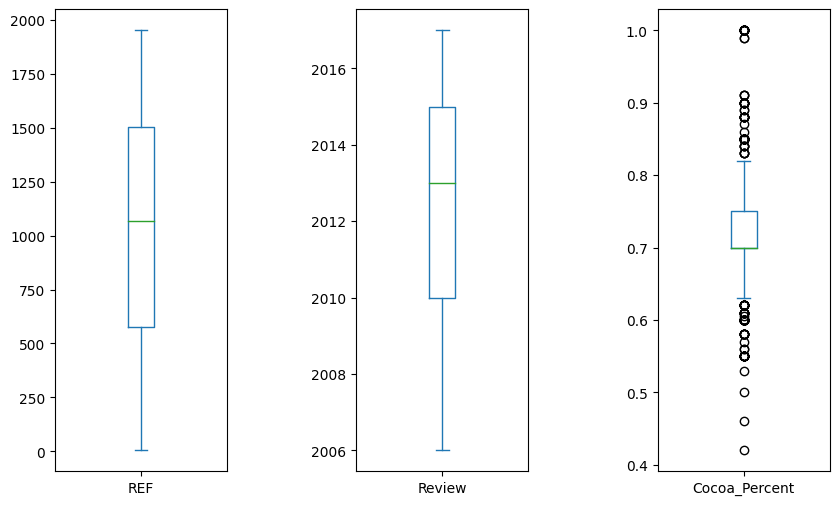

In [23]:
# Multiple boxplots in a single visualization.


df.plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6)) 

# increase spacing between subplots
plt.subplots_adjust(wspace = .75) # ws is the width of the padding between subplots, as a fraction of the average Axes width.
plt.show()

### Winsorization

In [24]:
winsor = Winsorizer(capping_method = 'iqr', # choose  IQR rule boundaries or gaussian for mean and std
                          tail = 'both', # cap left, right or both tails 
                          fold = 1.5,
                          variables = ['Cocoa_Percent'])

In [25]:
clean = winsor.fit(df[['Cocoa_Percent']])

In [26]:
df[['Cocoa_Percent']] = clean.transform(df[['Cocoa_Percent']])

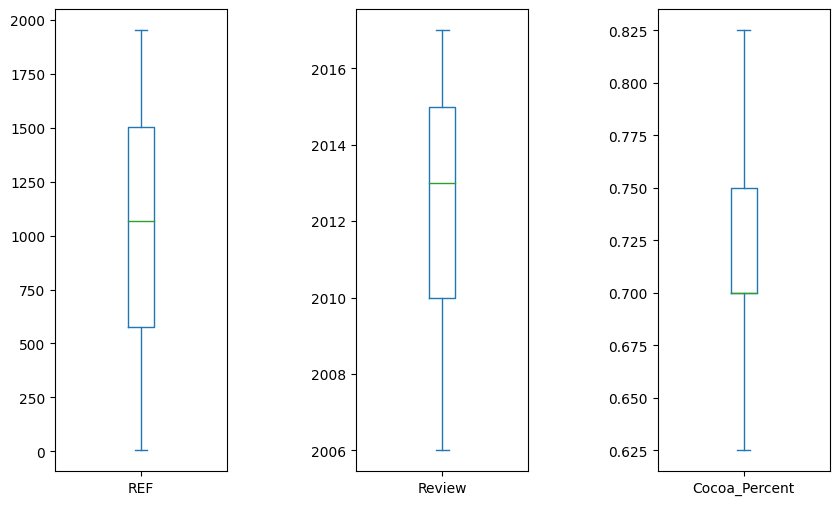

In [27]:
df.plot(kind = 'box', subplots = True, sharey = False, figsize = (10, 6)) 


# increase spacing between subplots
plt.subplots_adjust(wspace = 0.75) # ws is the width of the padding between subplots, as a fraction of the average Axes width.
plt.show()

In [28]:
# Checking for Null values
df.isnull().sum() 

Company             0
Name                0
REF                 0
Review              0
Cocoa_Percent       0
Company_Location    0
Bean_Type           1
Origin              1
dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1795 non-null   object 
 1   Name              1795 non-null   object 
 2   REF               1795 non-null   int64  
 3   Review            1795 non-null   int64  
 4   Cocoa_Percent     1795 non-null   float64
 5   Company_Location  1795 non-null   object 
 6   Bean_Type         1794 non-null   object 
 7   Origin            1794 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 112.3+ KB


In [30]:
df.columns

Index(['Company', 'Name', 'REF', 'Review', 'Cocoa_Percent', 'Company_Location',
       'Bean_Type', 'Origin'],
      dtype='object')

In [31]:
#df['Bean_Type'] = df['Bean_Type'].str.replace(' ', '')
#df['Bean_Type'] = df['Bean_Type'].str.replace('%', '')
#df['Bean_Type'] = df['Bean_Type'].str.replace('(', '')
#df['Bean_Type'] = df['Bean_Type'].str.replace(')', '')
#df['Bean_Type'] = df['Bean_Type'].str.replace('_', '')

In [32]:
#df['Origin'].unique()

In [33]:
#df['Bean_Type'].unique()

In [34]:
#df['Bean_Type'].value_counts()

#### Imputation to handle missing values on numerical columns

In [35]:
num_pipeline = Pipeline(steps = [('impute', SimpleImputer(strategy = 'mean'))])

In [36]:
preprocessor = ColumnTransformer(transformers = [('num', num_pipeline, numeric_features)])

In [37]:
imputation = preprocessor.fit(df)

In [38]:
df_num = pd.DataFrame(imputation.transform(df), columns = numeric_features)
df_num

,REF,Review,Cocoa_Percent
0,1876.0,2016.0,0.630
1,1676.0,2015.0,0.700
2,1676.0,2015.0,0.700
3,1680.0,2015.0,0.700
4,1704.0,2015.0,0.700
...,...,...,...
1790,647.0,2011.0,0.700
1791,749.0,2011.0,0.650
1792,749.0,2011.0,0.650
1793,781.0,2011.0,0.625


In [39]:
df_num.isnull().sum() 

REF              0
Review           0
Cocoa_Percent    0
dtype: int64

#### MinMaxScaler to convert the magnitude of the columns to a range of 0 to 1

In [40]:
scale_pipeline = Pipeline([('scale', MinMaxScaler())])

In [41]:
preprocess_pipeline1 = ColumnTransformer([('scale', scale_pipeline, numeric_features)])

In [42]:
scale = preprocess_pipeline1.fit(df_num)

In [43]:
scaled_data = pd.DataFrame(scale.transform(df_num))
scaled_data

,0,1,2
0,0.960966,0.909091,0.025
1,0.858243,0.818182,0.375
2,0.858243,0.818182,0.375
3,0.860298,0.818182,0.375
4,0.872625,0.818182,0.375
...,...,...,...
1790,0.329738,0.454545,0.375
1791,0.382126,0.454545,0.125
1792,0.382126,0.454545,0.125
1793,0.398562,0.454545,0.000


#### Mode Imputer

In [44]:
# Replacing junk value to numpy nan value and later imputed by using simple imputer with most frequent value.

In [45]:
df['Origin'].replace('\xa0', np.nan, inplace= True)

In [46]:
df['Bean_Type'].replace('\xa0', np.nan, inplace= True)

In [47]:
#df['Bean_Type'].unique()

In [48]:
#df['Origin'].unique()

In [49]:
df

,Company,Name,REF,Review,Cocoa_Percent,Company_Location,Bean_Type,Origin
0,A. Morin,Agua Grande,1876,2016,0.630,France,NaN,Sao Tome
1,A. Morin,Kpime,1676,2015,0.700,France,NaN,Togo
2,A. Morin,Atsane,1676,2015,0.700,France,NaN,Togo
3,A. Morin,Akata,1680,2015,0.700,France,NaN,Togo
4,A. Morin,Quilla,1704,2015,0.700,France,NaN,Peru
...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,0.700,Austria,NaN,Peru
1791,Zotter,Congo,749,2011,0.650,Austria,Forastero,Congo
1792,Zotter,Kerala State,749,2011,0.650,Austria,Forastero,India
1793,Zotter,Kerala State,781,2011,0.625,Austria,NaN,India


In [50]:
mode_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

In [51]:
df["Bean_Type"] = pd.DataFrame(mode_imputer.fit_transform(df[["Bean_Type"]]))

In [52]:
df["Origin"] = pd.DataFrame(mode_imputer.fit_transform(df[["Origin"]]))

In [53]:
df.isnull().sum()

Company             0
Name                0
REF                 0
Review              0
Cocoa_Percent       0
Company_Location    0
Bean_Type           0
Origin              0
dtype: int64

In [54]:
df.columns

Index(['Company', 'Name', 'REF', 'Review', 'Cocoa_Percent', 'Company_Location',
       'Bean_Type', 'Origin'],
      dtype='object')

In [55]:
df['Bean_Type'].unique()

array(['Trinitario', 'Criollo', 'Forastero (Arriba)', 'Forastero',
       'Forastero (Nacional)', 'Criollo, Trinitario',
       'Criollo (Porcelana)', 'Blend', 'Trinitario (85% Criollo)',
       'Forastero (Catongo)', 'Forastero (Parazinho)',
       'Trinitario, Criollo', 'CCN51', 'Criollo (Ocumare)', 'Nacional',
       'Criollo (Ocumare 61)', 'Criollo (Ocumare 77)',
       'Criollo (Ocumare 67)', 'Criollo (Wild)', 'Beniano', 'Amazon mix',
       'Trinitario, Forastero', 'Forastero (Arriba) ASS', 'Criollo, +',
       'Amazon', 'Amazon, ICS', 'EET', 'Blend-Forastero,Criollo',
       'Trinitario (Scavina)', 'Criollo, Forastero', 'Matina',
       'Forastero(Arriba, CCN)', 'Nacional (Arriba)',
       'Forastero (Arriba) ASSS', 'Forastero, Trinitario',
       'Forastero (Amelonado)', 'Trinitario, Nacional',
       'Trinitario (Amelonado)', 'Trinitario, TCGA', 'Criollo (Amarru)'],
      dtype=object)

In [56]:
# cate = ['Bean_Type']

#### Encoding - One Hot Encoder to convert Categorical data to Numeric values

In [57]:
#df_cate
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(df[categorical_data]))
df_cate = enc.transform(np.array(df[categorical_data])).toarray() #.sum()

In [58]:
len(df_cate)

1795

In [59]:
df_cate.sum()

8975.0

In [60]:
cate = pd.DataFrame(df_cate)
cate

,0,1,2,3,4,5,6,7,8,9,...,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# concatenate the data
clean_data = pd.concat([scaled_data, cate], axis = 1, ignore_index = True)

In [62]:
clean_data

,0,1,2,3,4,5,6,7,8,9,...,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656
0,0.960966,0.909091,0.025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.858243,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.858243,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.860298,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.872625,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,0.329738,0.454545,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1791,0.382126,0.454545,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1792,0.382126,0.454545,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1793,0.398562,0.454545,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Data split into Input and Output
X = clean_data.iloc[:,:]
X

,0,1,2,3,4,5,6,7,8,9,...,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656
0,0.960966,0.909091,0.025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.858243,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.858243,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.860298,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.872625,0.818182,0.375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,0.329738,0.454545,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1791,0.382126,0.454545,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1792,0.382126,0.454545,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1793,0.398562,0.454545,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
Y = comp_data['target']
Y

0       10
1        6
2        7
3        9
4        9
        ..
1790    10
1791     7
1792     9
1793     8
1794     7
Name: target, Length: 1795, dtype: int32

In [65]:
# Split data into train and test with Stratified sample technique

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 0)

In [66]:
X_train.shape

(1436, 1657)

In [67]:
X_test.shape

(359, 1657)

In [68]:
Y_train

911     10
232     11
1354     6
65       6
391     10
        ..
1510    10
486      6
951      6
939      9
1603     9
Name: target, Length: 1436, dtype: int32

In [69]:
# Proportion of Target variable categories are consistent across train and test

print(Y_train.value_counts()/1436)
print("\n")
print(Y_test.value_counts()/ 359)

9     0.218663
7     0.190111
8     0.168524
6     0.144150
10    0.116992
5     0.071031
11    0.054318
3     0.018106
4     0.007660
1     0.005571
0     0.002089
12    0.001393
2     0.001393
Name: target, dtype: float64


9     0.217270
7     0.189415
8     0.169916
6     0.144847
10    0.116992
5     0.069638
11    0.055710
3     0.016713
4     0.008357
1     0.005571
0     0.002786
2     0.002786
Name: target, dtype: float64


In [70]:
comp_data['target'].unique()

array([10,  6,  7,  9, 11,  8,  5, 12,  2,  1,  4,  3,  0])

In [71]:
comp_data['target'].value_counts()

9     392
7     341
8     303
6     259
10    210
5     127
11     98
3      32
4      14
1      10
0       4
2       3
12      2
Name: target, dtype: int64

# Random Forest Model

In [72]:
rf_Model = RandomForestClassifier()

#### Hyperparameters

In [71]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [2, 4]

min_samples_split = [2, 5]

min_samples_leaf = [1, 2]

bootstrap = [True, False]

In [72]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
n_estimators

[10, 17, 25, 33, 41, 48, 56, 64, 72, 80]

In [73]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


### Hyperparameter optimization with GridSearchCV

In [74]:
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 10, verbose = 2, n_jobs = -1)

In [75]:
rf_Grid.fit(X_train, Y_train)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [76]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 25}

In [77]:
cv_rf_grid = rf_Grid.best_estimator_
cv_rf_grid

RandomForestClassifier(bootstrap=False, max_depth=4, min_samples_split=5,
                       n_estimators=25)

## Check Accuracy

In [78]:
# Evaluation on Test Data
test_pred = cv_rf_grid.predict(X_test)

accuracy_test = np.mean(test_pred == Y_test)
accuracy_test

0.2200557103064067

[Text(0.5, 1.0, 'Company Rating Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

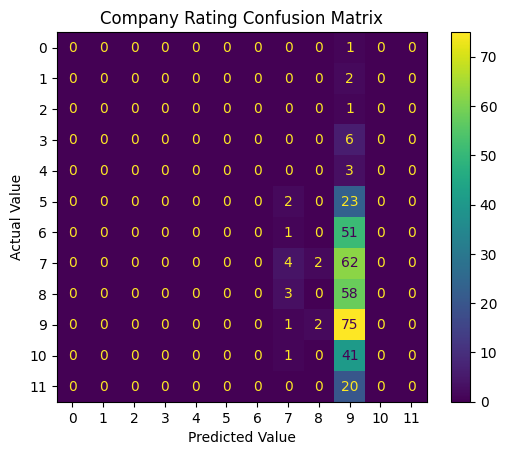

In [79]:
cm = skmet.confusion_matrix(Y_test, test_pred)

cmplot = skmet.ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ['Yes', 'No'])
cmplot.plot()
cmplot.ax_.set(title = 'Company Rating Confusion Matrix', 
               xlabel = 'Predicted Value', ylabel = 'Actual Value')

In [80]:
print (f'Train Accuracy - : {rf_Grid.score(X_train, Y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test, Y_test):.3f}')

Train Accuracy - : 0.253
Test Accuracy - : 0.220


# Hyperparameter optimization with RandomizedSearchCV

In [81]:
rf_Random = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose = 0, n_jobs = -1) 

In [82]:
rf_Random.fit(X_train, Y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]})

In [83]:
rf_Random.best_params_

{'n_estimators': 17,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 4,
 'bootstrap': False}

In [84]:
cv_rf_random = rf_Random.best_estimator_
cv_rf_random

RandomForestClassifier(bootstrap=False, max_depth=4, min_samples_leaf=2,
                       n_estimators=17)

In [85]:
# Evaluation on Test Data
test_pred_random = cv_rf_random.predict(X_test)

accuracy_test_random = np.mean(test_pred_random == Y_test)
accuracy_test_random

0.2200557103064067

[Text(0.5, 1.0, 'Company Rating Confusion Matrix'),
 Text(0.5, 0, 'Predicted Value'),
 Text(0, 0.5, 'Actual Value')]

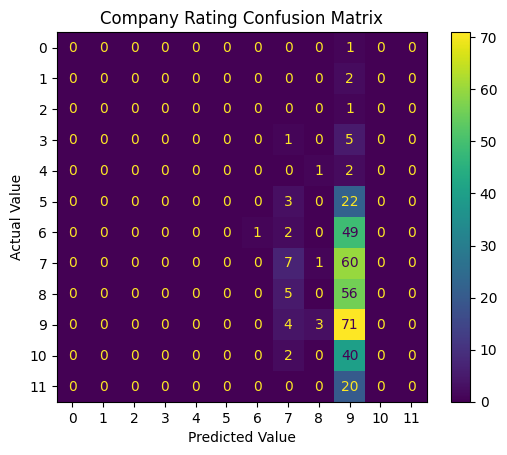

In [86]:
cm = skmet.confusion_matrix(Y_test, test_pred_random)

cmplot = skmet.ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ['Yes', 'No'])
cmplot.plot()
cmplot.ax_.set(title = 'Company Rating Confusion Matrix', 
               xlabel = 'Predicted Value', ylabel = 'Actual Value')

In [87]:
print (f'Train Accuracy - : {rf_Random.score(X_train, Y_train):.3f}')
print (f'Test Accuracy - : {rf_Random.score(X_test, Y_test):.3f}')

Train Accuracy - : 0.256
Test Accuracy - : 0.220


# Cross Validation implementation

In [88]:
from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv = 5):
    
    '''Function to perform 5 Folds Cross-Validation
    Parameters
    ----------
    model: Python Class, default=None
          This is the machine learning algorithm to be used for training.
    _X: array
       This is the matrix of features.
    _y: array
       This is the target variable.
    _cv: int, default=5
      Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dictionary containing the metrics 'accuracy', 'precision',
    'recall', 'f1' for both training set and validation set.
    '''
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                           X = _X,
                           y = _y,
                           cv = _cv,
                           scoring = _scoring,
                           return_train_score = True)

    return pd.DataFrame({"Training Accuracy scores": results['train_accuracy'],
          "Mean Training Accuracy": results['train_accuracy'].mean()*100,
          "Training Precision scores": results['train_precision'],
          "Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          "Mean Training Recall": results['train_recall'].mean(),
          "Training F1 scores": results['train_f1'],
          "Mean Training F1 Score": results['train_f1'].mean(),
          "Validation Accuracy scores": results['test_accuracy'],
          "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          "Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          "Mean Validation Recall": results['test_recall'].mean(),
          "Validation F1 scores": results['test_f1'],
          "Mean Validation F1 Score": results['test_f1'].mean()
          })

In [89]:
Random_forest_result = cross_validation(cv_rf_random, X_train, Y_train, 5)

Random_forest_result

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
0,0.252613,26.584032,NaN,NaN,NaN,NaN,NaN,NaN,0.225694,22.632356,NaN,NaN,NaN,NaN,NaN,NaN
1,0.255004,26.584032,NaN,NaN,NaN,NaN,NaN,NaN,0.233449,22.632356,NaN,NaN,NaN,NaN,NaN,NaN
2,0.274151,26.584032,NaN,NaN,NaN,NaN,NaN,NaN,0.216028,22.632356,NaN,NaN,NaN,NaN,NaN,NaN
3,0.285466,26.584032,NaN,NaN,NaN,NaN,NaN,NaN,0.250871,22.632356,NaN,NaN,NaN,NaN,NaN,NaN
4,0.261967,26.584032,NaN,NaN,NaN,NaN,NaN,NaN,0.205575,22.632356,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12, 6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        plt.ylim(0.40000, 1)
        plt.bar(X_axis - 0.2, train_data, 0.1, color = 'blue', label = 'Training')
        plt.bar(X_axis + 0.2, val_data, 0.1, color = 'red', label = 'Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

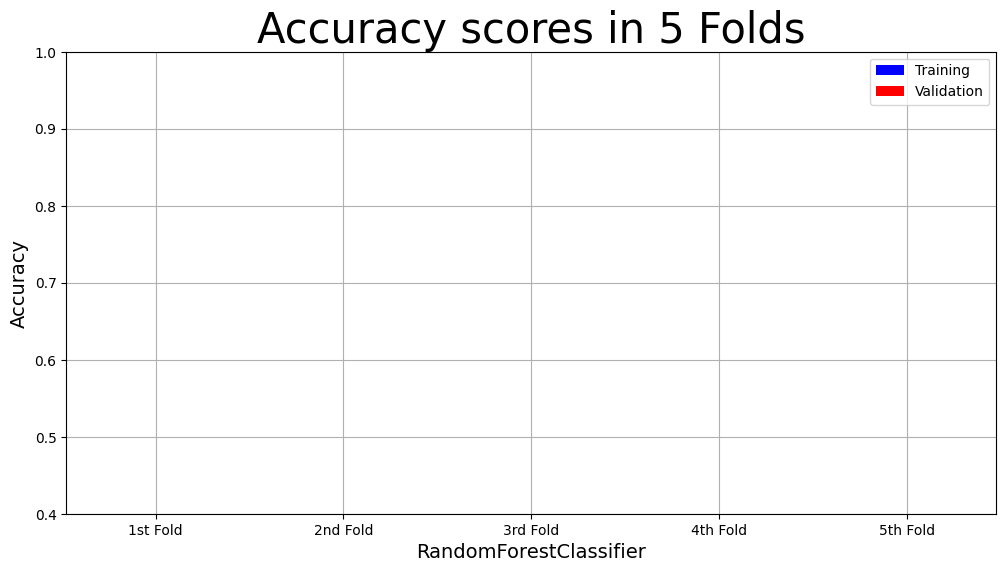

In [91]:
model_name = "RandomForestClassifier"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            Random_forest_result["Training Accuracy scores"],
            Random_forest_result["Validation Accuracy scores"])

# Bagging Classifier Model

In [73]:
clftree = tree.DecisionTreeClassifier()

In [74]:
bag_clf = BaggingClassifier(base_estimator = clftree, n_estimators = 500,
                            bootstrap = True, n_jobs = -1, random_state = 42)

In [75]:
# Fit the model 
n_jobs = -1
bag_clf = BaggingClassifier(base_estimator = clftree, n_estimators = 500,
                            bootstrap = True, n_jobs = -1, random_state = 42)
bagging = bag_clf.fit(X_train, Y_train)

In [76]:
print(confusion_matrix(Y_train, bagging.predict(X_train)))
print(accuracy_score(Y_train, bagging.predict(X_train)))
print('\n')
print(confusion_matrix(Y_test, bagging.predict(X_test)))
print(accuracy_score(Y_test, bagging.predict(X_test)))

[[  3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   8   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  26   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  11   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 102   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 207   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 273   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 242   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 314   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 168   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1  77   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   2]]
0.9993036211699164


[[ 0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  2  0  2  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  2  0  1  0  0  0]
 [ 0  0  0  1  0  1  2 10  5  6  0  0]
 [ 0  0  0  1  0  3 12 13  8 

In [78]:

from sklearn.metrics import mean_squared_error ,r2_score
# Evaluation on Testing Data
# getting error value
print("MSE(Test)-",mean_squared_error(Y_test, bag_clf.predict(X_test)))
# R^2 scuare value
print("R^2(Test)-",r2_score(Y_test, bag_clf.predict(X_test)))

# Evaluation on Training Data

# getting error value
print("MSE(Train)-",mean_squared_error(Y_train, bag_clf.predict(X_train)))
# R^2 scuare value
print("R^2(Train)-",r2_score(Y_train, bag_clf.predict(X_train)))

MSE(Test)- 4.030640668523677
R^2(Test)- -0.11491161800434391
MSE(Train)- 0.0006963788300835655
R^2(Train)- 0.9998049619791307


In [96]:
bagging

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, random_state=42)

# Cross Validation implementation

In [97]:
from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
    
    '''Function to perform 5 Folds Cross-Validation
    Parameters
    ----------
    model: Python Class, default=None
          This is the machine learning algorithm to be used for training.
    _X: array
       This is the matrix of features.
    _y: array
       This is the target variable.
    _cv: int, default=5
      Determines the number of folds for cross-validation.
    Returns
    -------
    The function returns a dictionary containing the metrics 'accuracy', 'precision',
    'recall', 'f1' for both training set and validation set.
    '''
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                           X=_X,
                           y=_y,
                           cv=_cv,
                           scoring=_scoring,
                           return_train_score=True)

    return pd.DataFrame({"Training Accuracy scores": results['train_accuracy'],
          "Mean Training Accuracy": results['train_accuracy'].mean()*100,
          "Training Precision scores": results['train_precision'],
          "Mean Training Precision": results['train_precision'].mean(),
          "Training Recall scores": results['train_recall'],
          "Mean Training Recall": results['train_recall'].mean(),
          "Training F1 scores": results['train_f1'],
          "Mean Training F1 Score": results['train_f1'].mean(),
          "Validation Accuracy scores": results['test_accuracy'],
          "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
          "Validation Precision scores": results['test_precision'],
          "Mean Validation Precision": results['test_precision'].mean(),
          "Validation Recall scores": results['test_recall'],
          "Mean Validation Recall": results['test_recall'].mean(),
          "Validation F1 scores": results['test_f1'],
          "Mean Validation F1 Score": results['test_f1'].mean()
          })

In [98]:
Bagging_cv_scores = cross_validation(bag_clf, X_train, Y_train, 5)

Bagging_cv_scores

,Training Accuracy scores,Mean Training Accuracy,Training Precision scores,Mean Training Precision,Training Recall scores,Mean Training Recall,Training F1 scores,Mean Training F1 Score,Validation Accuracy scores,Mean Validation Accuracy,Validation Precision scores,Mean Validation Precision,Validation Recall scores,Mean Validation Recall,Validation F1 scores,Mean Validation F1 Score
0,0.999129,99.947766,NaN,NaN,NaN,NaN,NaN,NaN,0.239583,24.512921,NaN,NaN,NaN,NaN,NaN,NaN
1,0.999130,99.947766,NaN,NaN,NaN,NaN,NaN,NaN,0.216028,24.512921,NaN,NaN,NaN,NaN,NaN,NaN
2,1.000000,99.947766,NaN,NaN,NaN,NaN,NaN,NaN,0.264808,24.512921,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000000,99.947766,NaN,NaN,NaN,NaN,NaN,NaN,0.240418,24.512921,NaN,NaN,NaN,NaN,NaN,NaN
4,0.999130,99.947766,NaN,NaN,NaN,NaN,NaN,NaN,0.264808,24.512921,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

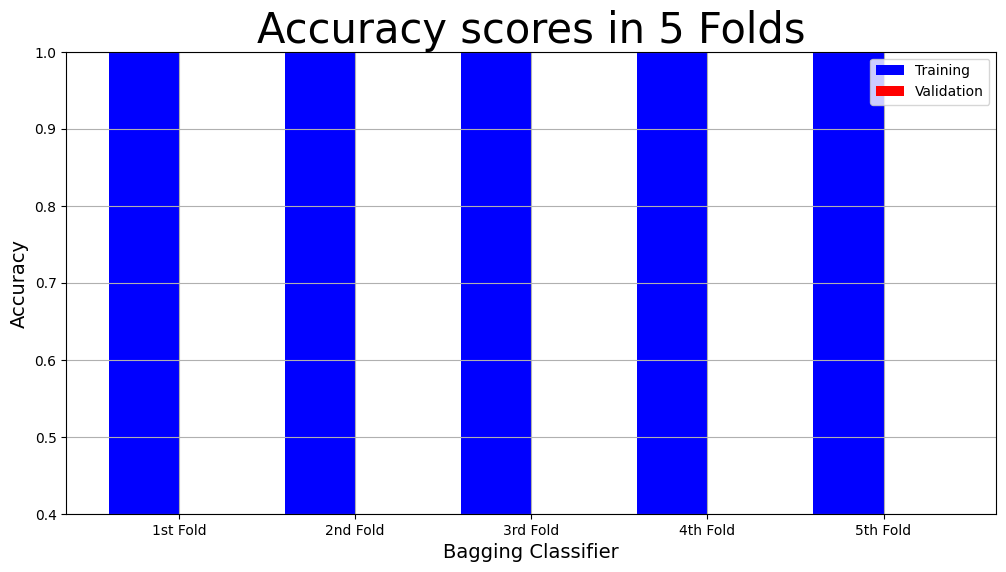

In [100]:
%matplotlib inline
model_name = "Bagging Classifier"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            Bagging_cv_scores["Training Accuracy scores"],
            Bagging_cv_scores["Validation Accuracy scores"])

# AdaBoosting

In [101]:
ada_clf = AdaBoostClassifier(learning_rate = 0.02, n_estimators = 5000)

ada_clf1 = ada_clf.fit(X_train, Y_train)

In [102]:
predictions = ada_clf1.predict(X_test)

In [103]:
# Evaluation on Testing Data
confusion_matrix(Y_test, predictions)

array([[ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  1,  0,  1,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  0],
       [ 0,  0,  0,  2,  1,  0,  2, 12,  0,  8,  0,  0],
       [ 0,  0,  0,  3,  9,  0,  7, 19,  0, 14,  0,  0],
       [ 0,  1,  0,  5,  6,  0,  7, 32,  0, 17,  0,  0],
       [ 0,  0,  0,  1,  9,  0,  2, 29,  0, 20,  0,  0],
       [ 0,  0,  0,  2, 11,  0,  2, 35,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  5,  0,  2, 21,  0, 14,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 13,  0,  5,  0,  0]], dtype=int64)

In [104]:
accuracy_score(Y_test, predictions)

0.19220055710306408

In [105]:
# Evaluation on Training Data
accuracy_score(Y_train, ada_clf1.predict(X_train))

0.2193593314763231

# GradientBoosting

In [ ]:
boost_clf = GradientBoostingClassifier()

boost_clf1 = boost_clf.fit(X_train, Y_train)

In [ ]:
grad_pred = boost_clf1.predict(X_test)

In [ ]:
boost_clf1

In [ ]:
print(confusion_matrix(Y_test, grad_pred))
print(accuracy_score(Y_test, grad_pred))

In [ ]:
print(confusion_matrix(Y_train, boost_clf1.predict(X_train)))
print(accuracy_score(Y_train, boost_clf1.predict(X_train)))

In [ ]:
# Hyperparameters
boost_clf2 = GradientBoostingClassifier(learning_rate = 0.02, n_estimators = 1000, max_depth = 1)


In [ ]:
boost_clf_p = boost_clf2.fit(X_train, Y_train)

In [ ]:
grad_pred_p = boost_clf_p.predict(X_test)

In [ ]:
boost_clf_p

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
# Evaluation on Testing Data
print(confusion_matrix(Y_test, grad_pred_p))
print('\n')
print(accuracy_score(Y_test,grad_pred_p))

In [ ]:
# Evaluation on Training Data
print(confusion_matrix(Y_train, boost_clf_p.predict(X_train)))
accuracy_score(Y_train, boost_clf_p.predict(X_train))

# XGBoosting

In [ ]:
xgb_clf = xgb.XGBClassifier(max_depth = 5, n_estimators = 10000, 
                            learning_rate = 0.3, n_jobs = -1)

# n_jobs – Number of parallel threads used to run xgboost.
# learning_rate (float) – Boosting learning rate (xgb’s “eta”)

In [ ]:
xgb_clf1 = xgb_clf.fit(X_train, Y_train)

In [ ]:
xgb_pred = xgb_clf1.predict(X_test)

In [ ]:
# Evaluation on Testing Data

print(confusion_matrix(Y_test, xgb_pred))

accuracy_score(Y_test, xgb_pred)

In [ ]:
xgb.plot_importance(xgb_clf)

In [ ]:
fi = pd.DataFrame(xgb_clf1.feature_importances_.reshape(1, -1), columns = X_train.columns)
fi

# RandomizedSearchCV for XGB

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators = 500, learning_rate = 0.1, random_state = 42)


In [ ]:
# Grid Search
param_test1 = {'max_depth': range(3,10,2), 'gamma': [0.1, 0.2, 0.3],
               'subsample': [0.8, 0.9], 'colsample_bytree': [0.8, 0.9],
               'rag_alpha': [1e-2, 0.1, 1]}


xgb_RandomGrid = RandomizedSearchCV(estimator = xgb_clf, 
                                    param_distributions = param_test1, 
                                    cv = 5, verbose = 2, n_jobs = 4)

In [ ]:
Randomized_search1 = xgb_RandomGrid.fit(X_train, Y_train)

In [ ]:
cv_xg_clf = Randomized_search1.best_estimator_

cv_xg_clf

In [ ]:
randomized_pred = cv_xg_clf.predict(X_test)

In [ ]:
# Evaluation on Testing Data with model with hyperparameter
accuracy_score(Y_test, randomized_pred)

In [ ]:
Randomized_search1.best_params_

In [ ]:
r_xgb = Randomized_search1.best_params_
r_xgb

In [ ]:
randomized_pred_1 = cv_xg_clf.predict(X_train)

In [ ]:
# Evaluation on Training Data with model with hyperparameters
accuracy_score(Y_train, randomized_pred_1)